In [1]:
import os
import sys
import json
import time
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from scipy import integrate, signal, fftpack, stats, ndimage
import statsmodels.stats.multitest as multitest

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [4]:
%matplotlib notebook

In [5]:
plt.rcParams.update({'font.size': 12})

Load CCF for identifying cortical areas

In [6]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [7]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [8]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
#     'VIS-TH': [
#         'LD', 'LGd-sh', 'LGd-co', 'LGd-ip', 'LGv', 'LP', 'MGd', 'MGm', 'MGv'
#     ] # CK said MGd/m/v is auditory?
}

area_colors = {
    'MO': 'blue',
    'ACA': 'deepskyblue',
    'SS': 'blueviolet',
    'VIS': 'green',
    'MO-TH': 'steelblue',
}

In [9]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}

#### Functions

In [10]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

In [11]:
def get_responsive_pvalue(spike_times, spike_clusters, unit_ids, events, response_window=[0.002, 0.1], apply_mc_corr=True):
    wstat = np.zeros(len(unit_ids), dtype=float) * np.nan
    pvals = np.zeros(len(unit_ids), dtype=float) * np.nan
    spcounts = np.zeros(len(unit_ids), dtype=float) * np.nan
    
    for indi, uniti in enumerate(unit_ids):
        spikesi = np.squeeze(spike_times[spike_clusters == uniti])

        pre_spcounts = np.zeros(len(events), dtype=int)
        post_spcounts = np.zeros(len(events), dtype=int)
        for j, E in enumerate(events):
            pre_spcounts[j] = np.sum((spikesi >= E-response_window[1]) & (spikesi <= E-response_window[0]))
            post_spcounts[j] = np.sum((spikesi >= E+response_window[0]) & (spikesi <= E+response_window[1]))
        
#         if (post_spcounts - pre_spcounts).any():
            # stats.wilcoxon tests whether the differences x-y is symmetric about zero #
        wstat[indi], pvals[indi] = stats.wilcoxon(x=post_spcounts, y=pre_spcounts, zero_method='zsplit')
            # added zero-method as zsplit because many of the units have too few non-zero samples #
            # this includes the zeros in ranking, but splits them evenly between positive and negative difference ranks #
        spcounts[indi] = np.mean(post_spcounts) - np.mean(pre_spcounts)
        
    if apply_mc_corr:
#         print('Applying multiple comparisons correction...')
        rej, pvals = multitest.fdrcorrection(pvals) #, alpha=0.01) # default alpha=0.05

    return pvals, spcounts

### Define data path

In [12]:
rec_folder = r'F:\EEG_exp\mouse551397\estim_vis_2021-02-11_10-45-23\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

comp_states = {
    'MOs_1200': {'awake': [0], 'anesthetized': [1]},
}

Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.


In [13]:
# Make a folder in my OneDrive to save plots
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)
figsavedir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs\pop_timing'
if not os.path.exists(figsavedir):
    os.mkdir(figsavedir)
    
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

estim_vis


#### Load stim table and speed signal

In [14]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good
0,biphasic,30,313.21234,313.21274,0.0004,0,True
1,biphasic,10,317.12436,317.12476,0.0004,0,True
2,biphasic,10,321.22743,321.22783,0.0004,0,True
3,biphasic,50,325.47838,325.47878,0.0004,0,True
4,biphasic,50,329.56234,329.56274,0.0004,0,True


In [15]:
run_signal, run_timestamps = exp.load_running()

In [16]:
## Grab exp metadata from Zap_Zip-log_exp ##
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(exp.mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(exp.experiment_folder))))
)].squeeze()
        
## Get PCI_stim_amp from metadata ##
currentstr = exp_meta['Current (uA)'].replace(' ','')
currents_list = []
for char in currentstr.split('/'):
    if char.isdecimal():
        currents_list.append(char)
if len(currents_list) > 1:
    PCI_stim_amp = currents_list[1]
elif len(currents_list) == 1:
    PCI_stim_amp = currents_list[0]
else:
    print('No stim current listed in Zap_Zip-log_exp')
print(currents_list)
print(PCI_stim_amp)

['10', '30', '50']
30


#### Load unit data

In [17]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeF']


In [18]:
probe_unit_data = {}
probe_LFP_data = {}
total_units = 0
for probei in probe_list:
    print(probei)
    probe_unit_data[probei] = {}
    probe_LFP_data[probei] = {}
    ## Load probe_info.json ##
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    npx_allch = np.array(data['channel']) # this is an array from 0 to 384
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip (ch 0 is 20 um from tip)
    ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"
    print(' surface channel: {:d}'.format(surface_ch))
    
    ## Get all ch depths ##
    npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
    probe_unit_data[probei]['ch_depths'] = allch_z[surface_ch] - allch_z
    
    ## Get saline chs for re-ref ##
    if surface_ch + 25 > 384:
        probe_LFP_data[probei]['saline_chs'] = np.arange(383, 378, -1)
    else:
        probe_LFP_data[probei]['saline_chs'] = np.arange(surface_ch + 15, surface_ch + 25)
    if 'area_ch' in data.keys():
        probe_LFP_data[probei]['ch_areas'] = np.array(data['area_ch'])
        probe_LFP_data[probei]['pop_chs'] = {key: [] for key in list(areas_of_interest.keys())}
        probe_LFP_data[probei]['pop_ch_depths'] = {key: [] for key in list(areas_of_interest.keys())}
        for chind in npx_allch:
            parent_region = [
                k for k in list(areas_of_interest.keys()) if probe_LFP_data[probei]['ch_areas'][chind] in areas_of_interest[k]
            ]
            if len(parent_region) == 1:
                probe_LFP_data[probei]['pop_chs'][parent_region[0]].append(chind)
                probe_LFP_data[probei]['pop_ch_depths'][parent_region[0]].append(probe_unit_data[probei]['ch_depths'][chind])
    
    ## Select units and get peak chs ##
    select_units, peak_chs, unit_metrics = exp.get_probe_units(probei)
    unit_metrics['cell_type'] = unit_metrics['duration'].apply(lambda x: 'FS' if x <= 0.4 else 'RS')
    print(' unit count: {:d}'.format(len(select_units)))
    
    ## Sort units ##
    all_units = select_units[np.squeeze(np.argsort(peak_chs))]
    all_units_chs = peak_chs[np.squeeze(np.argsort(peak_chs))]
    all_units_types = unit_metrics['cell_type'].values[np.squeeze(np.argsort(peak_chs))]
    probe_unit_data[probei]['units'] = all_units
    probe_unit_data[probei]['chs'] = all_units_chs
    probe_unit_data[probei]['cell_type'] = all_units_types
    if 'area' in unit_metrics.columns:
        all_units_areas = unit_metrics.area.values[np.squeeze(np.argsort(peak_chs))]
        probe_unit_data[probei]['areas_assigned'] = True
        probe_unit_data[probei]['areas'] = all_units_areas
    else:
        print(' unit metrics file does not have area assignments.')
        probe_unit_data[probei]['areas_assigned'] = False
    total_units += len(probe_unit_data[probei]['units'])
            
    ## Load spike times and cluster ids ##
    probe_unit_data[probei]['spike_times'] = np.load(exp.ephys_params[probei]['spike_times'])
    probe_unit_data[probei]['spike_clusters'] = np.load(exp.ephys_params[probei]['spike_clusters'])
print('Total unit count: {:d}'.format(total_units))

probeB
 surface channel: 370
 unit count: 331
probeF
 surface channel: 275
 unit count: 276
Total unit count: 607


## Get trial times

In [19]:
rest_trials_only = True
all_event_times = {}
for expdes, state_sweeps in comp_states.items():
    print(expdes)
    all_event_times[expdes] = {}
    for parami in currents_list:
        print('biphasic - {} \u03bcA'.format(parami))
        all_event_times[expdes][parami] = {}
        for statei, sweeps in state_sweeps.items():
            ## Get all event times for statei ##
            state_events = []
            for sweepi in sweeps:
                events = get_stim_events(stim_log, 'biphasic', parami, sweepi)
                if len(events) == 0:
                    continue
                state_events.append(events)
            state_events = np.concatenate(state_events)

            ## Get mean speed for all events ##
            rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
            event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
            mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
            rest_events = np.nonzero(mean_speed == 0)[0]
            print(' {} state: resting trials {:d}/{:d}'.format(statei, len(rest_events), len(state_events)))

            if rest_trials_only:
                all_event_times[expdes][parami][statei] = state_events[rest_events]
            else:
                all_event_times[expdes][parami][statei] = state_events

MOs_1200
biphasic - 10 μA
 awake state: resting trials 85/120
 anesthetized state: resting trials 120/120
biphasic - 30 μA
 awake state: resting trials 96/120
 anesthetized state: resting trials 120/120
biphasic - 50 μA
 awake state: resting trials 96/120
 anesthetized state: resting trials 120/120


### Categorize responsive units

In [20]:
raster_window = [-1.0, 1.0]
spcount_window = [0.002, 0.025] # [0.002, 0.025] [0.025, 0.125]
alpha = 0.05

In [21]:
unit_trial_spikes = {}
unit_responses = {}
pop_LFP = {}
for expdes in all_event_times.keys():
    unit_trial_spikes[expdes] = {}
    unit_responses[expdes] = {}
    pop_LFP[expdes] = {}
    for parami, statesevents in all_event_times[expdes].items():
        unit_trial_spikes[expdes][parami] = {}
        unit_responses[expdes][parami] = {}
        pop_LFP[expdes][parami] = {}
        for statei, events in statesevents.items():
            unit_trial_spikes[expdes][parami][statei] = {}
            pop_LFP[expdes][parami][statei] = {key: [] for key in list(areas_of_interest.keys())}
            ## Loop through probes to get unit responsiveness ##
            units_list = []
            areas_list = []
            parents_list = []
            depths_list = []
            types_list = []
            response_list = []
            for probei, unit_data in probe_unit_data.items():
                ## Get trial spikes for each unit ##
                for unitind, uniti in enumerate(unit_data['units']):
                    spikesi = np.squeeze(unit_data['spike_times'][unit_data['spike_clusters'] == uniti])
                    event_raster = []
                    for eventi in events:
                        spikeinds = np.squeeze(
                            np.argwhere((spikesi > eventi + raster_window[0]) & (spikesi < eventi + raster_window[1]))
                        )
                        event_raster.append(spikesi[spikeinds] - eventi)
                    unit_trial_spikes[expdes][parami][statei][probei[-1] + str(uniti)] = event_raster
                ## Get responsiveness ##
                unit_ids = [probei[-1] + str(x) for x in unit_data['units']]
                unit_pvals, unit_spcounts = get_responsive_pvalue(
                    unit_data['spike_times'],
                    unit_data['spike_clusters'],
                    unit_data['units'],
                    events,
                    spcount_window,
                )

                ## Loop through all units and add to the correct population ##
                probe_parent_list = []
                probe_response_list = []
                for unitind in range(unit_pvals.shape[0]):
                    parent_region = [
                        key for key in list(areas_of_interest.keys()) if unit_data['areas'][unitind] in areas_of_interest[key]
                    ]
                    if unit_pvals[unitind] < alpha and unit_spcounts[unitind] > 0:
                        probe_response_list.append('excited')
                    elif unit_pvals[unitind] < alpha and unit_spcounts[unitind] < 0:
                        probe_response_list.append('inhibited')
                    else:
                        probe_response_list.append('ns')
                    if len(parent_region) == 1:
                        probe_parent_list.append(parent_region[0])
                    else:
                        probe_parent_list.append('none')

                units_list.append(unit_ids)
                areas_list.append(unit_data['areas'])
                parents_list.append(probe_parent_list)
                depths_list.append(unit_data['ch_depths'][unit_data['chs']])
                types_list.append(unit_data['cell_type'])
                response_list.append(probe_response_list)
                
                ## Memmap LFP data ##
                rawmm = np.memmap(exp.ephys_params[probei]['lfp_continuous'], dtype='int16', mode='r')
                lfp_data_mm = np.reshape(
                    rawmm, (int(rawmm.size/exp.ephys_params[probei]['num_chs']), exp.ephys_params[probei]['num_chs']))
                lfp_ts = np.load(exp.ephys_params[probei]['lfp_timestamps'])
                lfp_event_traces, lfp_event_ts = get_evoked_traces(
                    lfp_data_mm, lfp_ts, events, -raster_window[0], raster_window[1], exp.ephys_params[probei]['lfp_sample_rate']
                )
                ## Re-ref to saline and convert to bits ##
                ref_trace = np.mean(lfp_event_traces[:, probe_LFP_data[probei]['saline_chs'], :], axis=1)
                lfp_event_traces = (lfp_event_traces - ref_trace[:, None, :]) * exp.ephys_params[probei]['bit_volts']
                ## Low pass filter ##
                filtb, filta = signal.butter(
                    3, np.array([0.1, 100])/(exp.ephys_params[probei]['lfp_sample_rate']/2), btype='bandpass')
                lfp_event_traces = signal.filtfilt(filtb, filta, lfp_event_traces, axis=0)
                for region in probe_LFP_data[probei]['pop_chs'].keys():
                    pop_chs = probe_LFP_data[probei]['pop_chs'][region]
                    if len(pop_chs) == 0:
                        continue
                    pop_LFP[expdes][parami][statei][region].append(lfp_event_traces[:, pop_chs, :])

            ## Make a dataframe with all of the unit data
            unit_responses[expdes][parami][statei] = pd.DataFrame({
                'unit_id': np.concatenate(units_list),
                'area': np.concatenate(areas_list),
                'parent': np.concatenate(parents_list),
                'unit_depths': np.concatenate(depths_list),
                'cell_type': np.concatenate(types_list),
                'response': np.concatenate(response_list),
            })

In [22]:
pop_ch_depths = {key: [] for key in list(areas_of_interest.keys())}
pop_ch_areas = {key: [] for key in list(areas_of_interest.keys())}
for probei in probe_LFP_data.keys():
    for region in probe_LFP_data[probei]['pop_ch_depths'].keys():
        pop_ch_depths[region].append(probe_LFP_data[probei]['pop_ch_depths'][region])
        pop_ch_areas[region].append(probe_LFP_data[probei]['ch_areas'][probe_LFP_data[probei]['pop_chs'][region]])

### Set which data to analyze

In [23]:
ROI = ['MO', 'ACA', 'SS', 'MO-TH']
plot_cell_type = 'RS'
plot_response_type = 'excited'
plexp = 'MOs_1200'
plstim = '50'
plstate = 'awake' # 'anesthetized' 'awake'

In [24]:
peak_windows = {'early': [0.0, 0.025], 'late': [0.025, 0.225]}
time_bin = 0.005 # size of time bins (s) I used 0.001, NS used 0.005
gausswin = 0.01 # duration of convolution (s) I used 0.005, NS used 0.02

df = unit_responses[plexp][plstim][plstate]
bins = np.arange(raster_window[0], raster_window[1] + time_bin, time_bin)

### Plot all populations, stacked, with single trial LFP

<IPython.core.display.Javascript object>


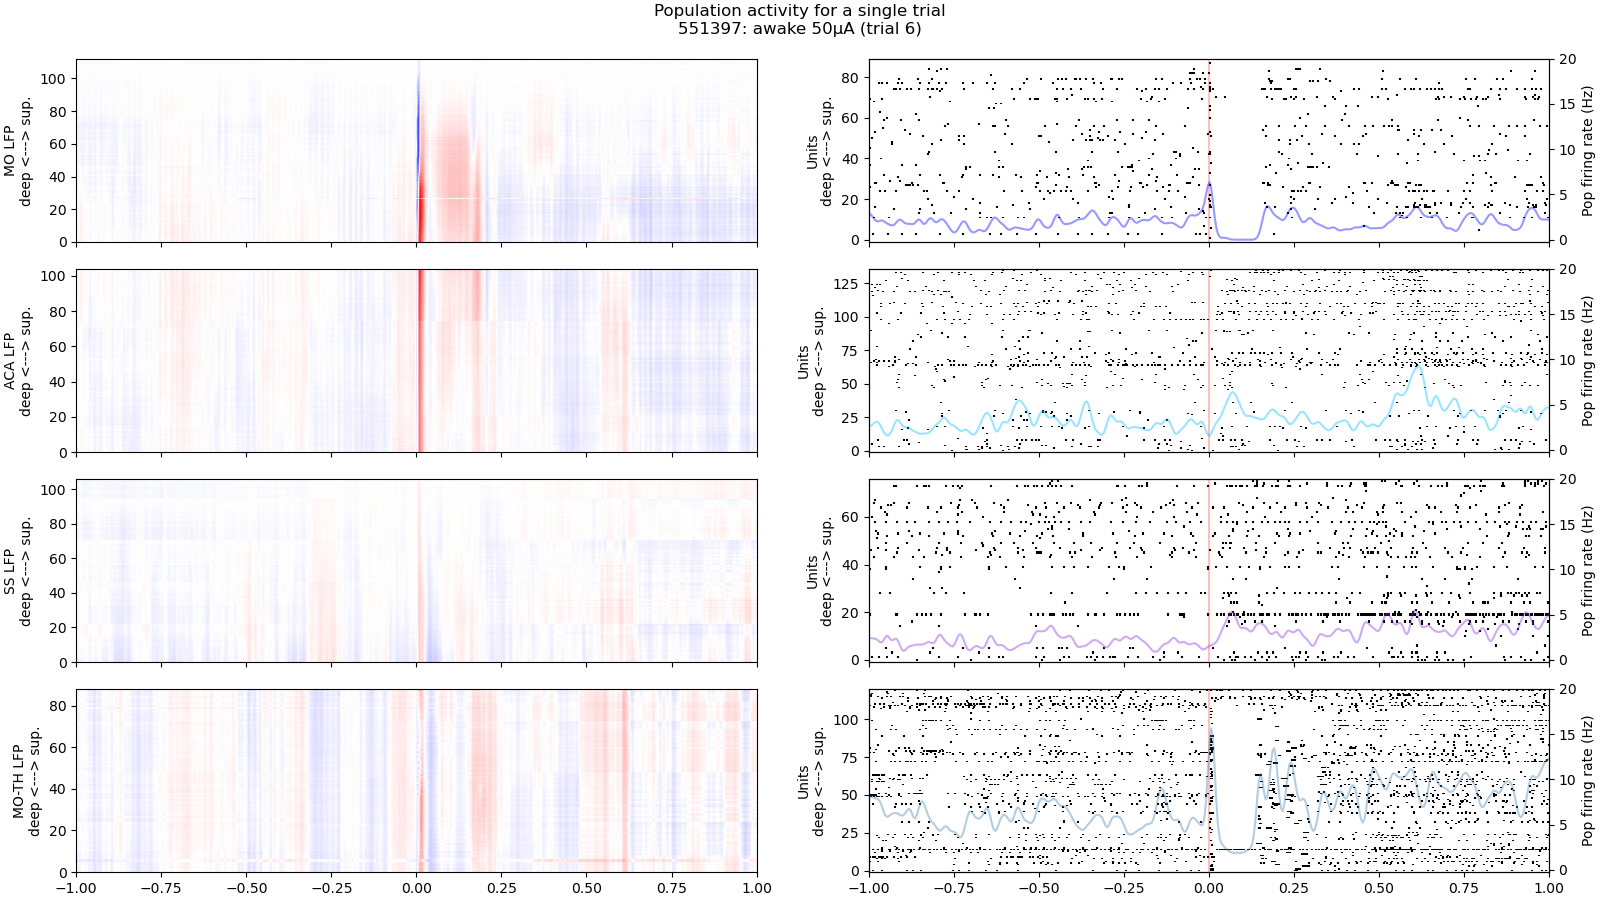

In [73]:
triali = 6
vlevel = 2000
fig, axs = plt.subplots(len(ROI), 2, figsize=(16,9), sharex=True, constrained_layout=True)
for rowi, region in enumerate(ROI):
    ## Plot LFP ##
    LFPtraces = np.concatenate(pop_LFP[plexp][plstim][plstate][region], axis=1)
    ch_depth_sort = np.squeeze(np.argsort(np.concatenate(pop_ch_depths[region], axis=0)))[::-1]
    axs[rowi,0].imshow(
        LFPtraces[:, ch_depth_sort, triali].T, cmap='bwr', interpolation='none', aspect='auto', origin='lower',
        vmin=-vlevel, vmax=vlevel, extent=[lfp_event_ts[0], lfp_event_ts[-1], 0, ch_depth_sort.shape[0]]
    )
    
    ## Plot spike raster ##
    select_units = df[df['parent'] == region].unit_id.values
    select_depths = df[df['parent'] == region].unit_depths.values
    depth_sort = np.squeeze(np.argsort(select_depths))[::-1] # in reverse order, because plots from bottom to top
    axs[rowi,1].axvline(0, color='r', alpha=0.25)

    pop_hist = []
    for indi, uniti in enumerate(select_units[depth_sort]):
        axs[rowi,1].eventplot(
            [unit_trial_spikes[plexp][plstim][plstate][uniti][triali]], lineoffsets=indi, linelengths=0.95, color='black')
        pop_counts, edges = np.histogram(unit_trial_spikes[plexp][plstim][plstate][uniti][triali], bins)
        pop_hist.append(pop_counts)

    axs[rowi,1].set_xlim(raster_window)
    axs[rowi,1].set_ylim([-1, indi+1])

    ## Population PSTH ##
    pop_bin_counts = np.sum(np.array(pop_hist), axis=0)
#     axs[1,coli].bar(bins[:-1] + time_bin/2, pop_bin_counts, width=time_bin*0.95, color='k')
#     axs[1,coli].set_xlabel('Time from stim onset (s)')
    SDFax = axs[rowi,1].twinx()
    SDFax.plot(
        bins[:-1] + time_bin/2, ndimage.gaussian_filter(pop_bin_counts, sigma=int(gausswin / time_bin), output=float),
        color=area_colors[region], linewidth=1.5, alpha=0.4
    )
    SDFax.set_ylim([-0.25, 20])
    SDFax.set_ylabel('Pop firing rate (Hz)')
    
    axs[rowi,0].set_ylabel('{} LFP\ndeep <---> sup.'.format(region))
    axs[rowi,1].set_ylabel('Units\ndeep <---> sup.')
    
plt.suptitle(
    'Population activity for a single trial\n{}: {} {}\u03bcA (trial {:d})'.format(
        exp.mouse, plstate, plstim, triali), fontsize=12)
## Save ##
figname = 'allPOP_LFPraster_{}_{}{}_trial{:d}.png'.format(exp.mouse, plstate, plstim, triali)
# fig.savefig(os.path.join(rasterdir, figname), transparent=False)

### Spike counting

#### Count spikes in response window and compare to baseline windows.

This method strongly relies on correctly choosing the count window...

In [61]:
count_window = [0.0, 0.008] # count spikes in first 25 ms
BL_tests = 100
regi = 'MO'
triali = 3

UOI = df[df['parent'] == regi].unit_id.values
Rcount = 0
for uniti in UOI:
    spikesi = unit_trial_spikes[plexp][plstim][plstate][uniti][triali]
    Rcount += np.sum((spikesi > count_window[0]) & (spikesi < count_window[1]))
    
BL_times = np.random.uniform(low=raster_window[0], high=count_window[0], size=(BL_tests))
BL_counts = np.zeros((BL_tests), dtype=int)
for i, bltime in enumerate(BL_times):
    count = 0
    for uniti in UOI:
        spikesi = unit_trial_spikes[plexp][plstim][plstate][uniti][triali]
        count += np.sum((spikesi > bltime + count_window[0]) & (spikesi < bltime + count_window[1]))
    BL_counts[i] = count
        
print(Rcount)
print('Baseline: avg={:.1f}, min={:d}, max={:d}'.format(np.mean(BL_counts), np.min(BL_counts), np.max(BL_counts)))

11
Baseline: avg=1.4, min=0, max=7


#### Count spikes in response window and compare across areas

In [62]:
count_window = [0.0, 0.025] # count spikes in first 25 ms

NUM_TRIALS = len(all_event_times[plexp][plstim][plstate])
all_spike_counts = {}
for region in ROI:
    UOI = df[df['parent'] == region].unit_id.values
    trial_counts = np.zeros((NUM_TRIALS), dtype=int)
    for triali in range(NUM_TRIALS):
        pcount = 0
        for uniti in UOI:
            spikesi = unit_trial_spikes[plexp][plstim][plstate][uniti][triali]
            pcount += np.sum((spikesi > count_window[0]) & (spikesi < count_window[1]))
        trial_counts[triali] = pcount
    all_spike_counts[region] = trial_counts

<IPython.core.display.Javascript object>


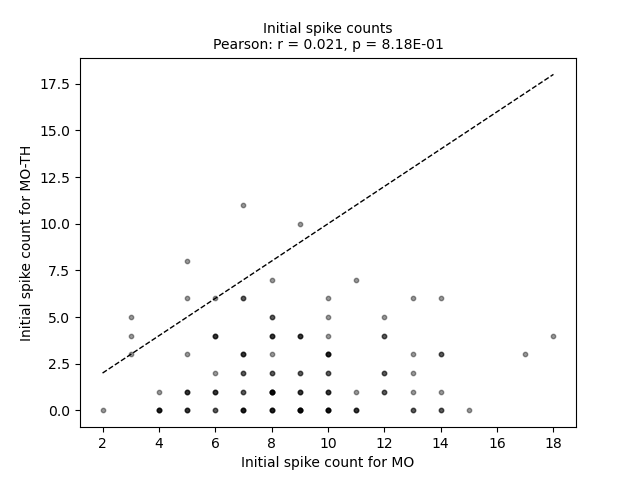

In [69]:
reg1 = 'MO'
reg2 = 'MO-TH'

pearson_r, pearson_p = stats.pearsonr(all_spike_counts[reg1], all_spike_counts[reg2])
fig, ax = plt.subplots()
ax.scatter(all_spike_counts[reg1], all_spike_counts[reg2], c='k', s=10, alpha=0.4)
ax.set_xlabel('Initial spike count for {}'.format(reg1))
ax.set_ylabel('Initial spike count for {}'.format(reg2))
ax.plot(
    [np.min(all_spike_counts[reg1]), np.max(all_spike_counts[reg1])],
    [np.min(all_spike_counts[reg1]), np.max(all_spike_counts[reg1])],
    linestyle='dashed', color='k', linewidth=1
)
ax.set_title('Initial spike counts\nPearson: r = {:.3f}, p = {:.2E}'.format(pearson_r, pearson_p))
if pearson_p < alpha:
    ax.annotate('*', xy=(0.9, 0.9), xycoords='axes fraction', color='r', fontsize=12, fontweight='bold', ha='center')

In [70]:
print(np.mean(all_spike_counts[reg2] / all_spike_counts[reg1]))

0.28287561839032427


### Investigating PSTH and firing thresholds

In [119]:
time_bin = 0.0001 # size of time bins (s) I used 0.001, NS used 0.005
gausswin = 0.0005 # duration of convolution (s) I used 0.005, NS used 0.02
df = unit_responses[plexp][plstim][plstate]
bins = np.arange(raster_window[0], raster_window[1] + time_bin, time_bin)

<IPython.core.display.Javascript object>


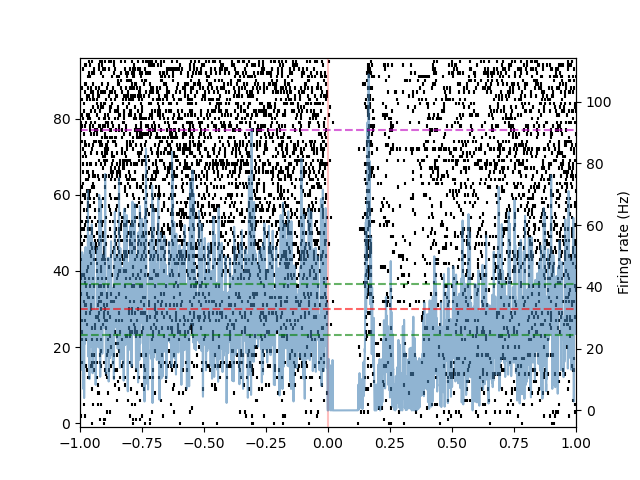

In [124]:
UOI = df[df['parent'] == 'MO'].unit_id.values
uniti = UOI[8]

fig, ax = plt.subplots()
ax.axvline(0, color='r', alpha=0.25)

psth = []
for indi, spikesi in enumerate(unit_trial_spikes[plexp][plstim][plstate][uniti]):
    ax.eventplot([spikesi], lineoffsets=indi, linelengths=0.95, color='black')
    sp_counts, edges = np.histogram(spikesi, bins)
    psth.append(sp_counts / time_bin)

ax.set_xlim(raster_window)
ax.set_ylim([-1, indi+1])

SDFax = ax.twinx()
timex = bins[:-1] + time_bin/2
SDF = np.mean(np.array(psth), axis=0)
SDFax.plot(
    timex, ndimage.gaussian_filter(SDF, sigma=int(gausswin / time_bin), output=float),
    color=area_colors[region], linewidth=1.5, alpha=0.6
)
SDFax.set_ylabel('Firing rate (Hz)')
SDFax.axhline(np.mean(SDF[timex < 0]), color='r', linestyle='dashed', alpha=0.6)
SDFax.axhline(np.mean(SDF[timex < 0]) * 1.25, color='g', linestyle='dashed', alpha=0.6)
SDFax.axhline(np.mean(SDF[timex < 0]) * 0.75, color='g', linestyle='dashed', alpha=0.6)
SDFax.axhline(np.mean(SDF[timex < 0]) + np.std(SDF[timex < 0]), color='m', linestyle='dashed', alpha=0.6)

In [86]:
np.array(psth).shape

(96, 20000)

## Different raster plot styles

Plot all populations, stacked

In [29]:
time_bin = 0.0001 # size of time bins (s) I used 0.001, NS used 0.005
gausswin = 0.0005 # duration of convolution (s) I used 0.005, NS used 0.02
bins = np.arange(raster_window[0], raster_window[1] + time_bin, time_bin)

<IPython.core.display.Javascript object>


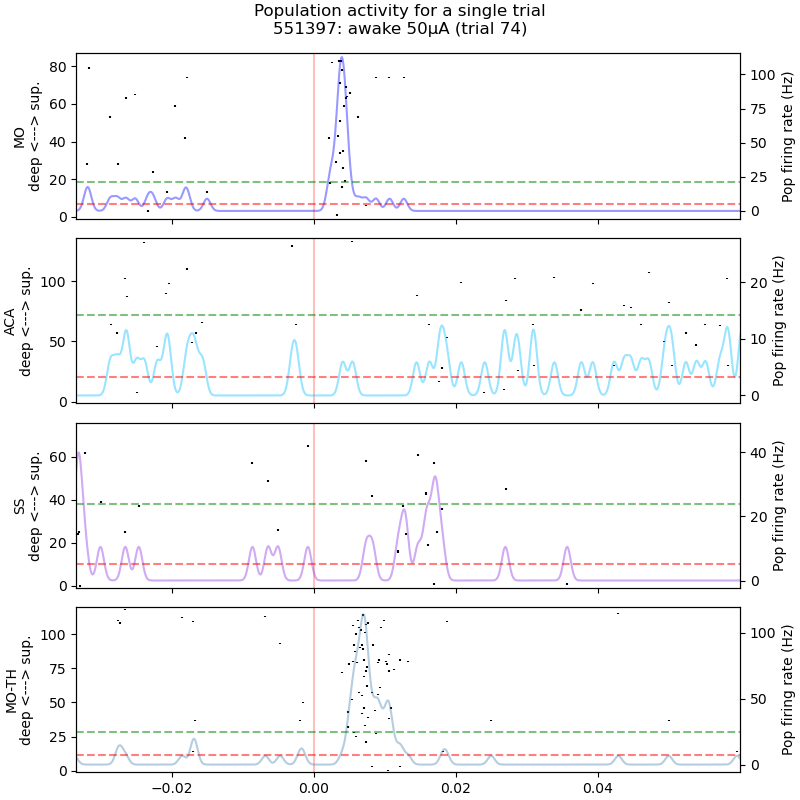

In [55]:
triali = 74

fig, axs = plt.subplots(len(ROI), figsize=(8,8), sharex=True, constrained_layout=True)
timex = bins[:-1] + time_bin/2
for rowi, region in enumerate(ROI):
    select_units = df[df['parent'] == region].unit_id.values
    select_depths = df[df['parent'] == region].unit_depths.values
    depth_sort = np.squeeze(np.argsort(select_depths))[::-1] # in reverse order, because plots from bottom to top

    ## Spike raster ##
    axs[rowi].axvline(0, color='r', alpha=0.25)

    pop_hist = []
    for indi, uniti in enumerate(select_units[depth_sort]):
        axs[rowi].eventplot(
            [unit_trial_spikes[plexp][plstim][plstate][uniti][triali]], lineoffsets=indi, linelengths=0.95, color='black')
        pop_counts, edges = np.histogram(unit_trial_spikes[plexp][plstim][plstate][uniti][triali], bins)
        pop_hist.append(pop_counts)

    axs[rowi].set_xlim(raster_window)
    axs[rowi].set_ylim([-1, indi+1])

    ## Population PSTH ##
    pop_bin_counts = np.mean(np.array(pop_hist), axis=0)
    popSDF = ndimage.gaussian_filter(pop_bin_counts, sigma=int(gausswin/time_bin), output=float) / time_bin
    SDFax = axs[rowi].twinx()
    SDFax.plot(timex, popSDF, color=area_colors[region], linewidth=1.5, alpha=0.4)
    SDFax.axhline(np.mean(popSDF[timex < 0]), color='r', linestyle='dashed', alpha=0.5)
    SDFax.axhline(np.mean(popSDF[timex < 0]) + 3 * np.std(popSDF[timex < 0]), color='g', linestyle='dashed', alpha=0.5)
    SDFax.set_ylabel('Pop firing rate (Hz)')
    
    axs[rowi].set_ylabel('{}\ndeep <---> sup.'.format(region))
    
plt.suptitle(
    'Population activity for a single trial\n{}: {} {}\u03bcA (trial {:d})'.format(
        exp.mouse, plstate, plstim, triali), fontsize=12)
## Save ##
figname = 'allPOP_rasterSDF_{}_{}{}_trial{:d}.png'.format(exp.mouse, plstate, plstim, triali)
# fig.savefig(os.path.join(plotsavedir, figname), transparent=False)

Integrate under SDF in initial response

In [72]:
regii = 'SS'
triali = 4
integrate_window = [0, 0.025]
zthresh = 3

pop_hist = []
for uniti in df[df['parent'] == regii].unit_id.values:
    pop_counts, edges = np.histogram(unit_trial_spikes[plexp][plstim][plstate][uniti][triali], bins)
    pop_hist.append(pop_counts)
pop_avg = np.mean(np.array(pop_hist), axis=0)
popSDF = ndimage.gaussian_filter(pop_avg, sigma=int(gausswin/time_bin), output=float) / time_bin
    
intinds = np.nonzero((timex >= integrate_window[0]) & (timex <= integrate_window[1]))[0]
thresh = np.mean(popSDF[timex < 0]) + zthresh * np.std(popSDF[timex < 0])

if np.any(popSDF[intinds] > thresh):
    print('Yes, SDF exceeds threshold in initial window.')
    has_response = True

    ## Find peak value and time ##
    peaks, props = signal.find_peaks(popSDF[intinds], height=thresh)
    maxind = np.argmax(popSDF[intinds[peaks]])
    peak_time = timex[intinds[peaks[maxind]]]
    peak_value = popSDF[intinds[peaks[maxind]]]
    print('The max firing rate is {:.1f} Hz and occurs at {:.2f} ms'.format(peak_value, peak_time*1E3))
    
    ## Find threshold crossing time ##
    cross_time = timex[intinds[np.argwhere(popSDF[intinds] > thresh)[0][0]]]
    print('The SDF first crosses threshold at {:.2f} ms'.format(cross_time*1E3))
    
    ## Measure AUC by subtracting threshold and removing negative values ##
    SDF_over_thresh = np.where((popSDF - thresh) < 0, 0.0, (popSDF - thresh))
    auc1 = integrate.simps(SDF_over_thresh[intinds], timex[intinds], axis=0, even='last')
    print(auc1)
    
else:
    print('no peak in first window')
    has_response = False

Yes, SDF exceeds threshold in initial window.
The max firing rate is 20.7 Hz and occurs at 22.85 ms
The SDF first crosses threshold at 22.75 ms
0.00010287564523344655
